In [21]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pandas as pd



In [22]:
from keras.datasets import mnist

In [23]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()
train_X, test_X = train_X / 255.0, test_X / 255.0

In [24]:
#model = keras.models.Sequential([keras.layers.Flatten(input_shape = (28,28)),
                               #keras.layers.Dense(128,activation = 'relu'),
                                # keras.layers.Dense(10)])

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape = (28,28)))
model.add(keras.layers.Dense(128,activation = 'relu'))
model.add(keras.layers.Dense(10))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [25]:
loss = keras.losses.SparseCategoricalCrossentropy(from_logits =True)
optim = keras.optimizers.Adam(learning_rate=0.001)
metrics = ['accuracy']
model.compile(optimizer = optim, loss= loss, metrics=metrics)
model.fit(train_X, train_y,batch_size=150,epochs=5 ,shuffle=True)

Epoch 1/5
400/400 [==============================] - 5s 12ms/step - loss: 0.3703 - accuracy: 0.8984
Epoch 2/5
400/400 [==============================] - 5s 11ms/step - loss: 0.1742 - accuracy: 0.9506
Epoch 3/5
400/400 [==============================] - 5s 12ms/step - loss: 0.1269 - accuracy: 0.9639
Epoch 4/5
400/400 [==============================] - 5s 11ms/step - loss: 0.0993 - accuracy: 0.9717
Epoch 5/5
400/400 [==============================] - 5s 12ms/step - loss: 0.0815 - accuracy: 0.9766


In [26]:
predicted = model.predict(test_X,batch_size=64)

In [27]:
pred = [np.argmax(i) for i in  tf.nn.softmax(predicted)]
pred[1]

2

In [28]:
class Network:
    def __init__(self,input_shape ,layers_size = [128,10],lr = 0.01):
        self.layers_size = layers_size
        self.input_shape = input_shape
        self.lr = lr
        self.layers_size.insert(0,self.input_shape[0] * self.input_shape[1])
        self.weights = [np.random.normal(size = (self.layers_size[i+1],self.layers_size[i])) for i in range(len(self.layers_size) - 1)]
        self.biases = [np.random.normal(size = (self.layers_size[i],1)) for i in range(1,len(self.layers_size))]
        
        
    def summary(self):
        print('Model: "sequential"')
        print('_________________________________________________________________')
        print('Layer (type)                 Output Shape              Param #   ')
        print('=================================================================')
        all_params = 0
        for i in range(len(self.layers_size)):
            if i == 0:
                print(f'flatten (Flatten)            (None, {self.layers_size[i]})               0   ')
                print('_________________________________________________________________')
            else:
                params = (self.layers_size[i-1] + 1) * self.layers_size[i]
                all_params += params
                if i - 1 == 0:
                    print(f'dense (Dense)              (None, {self.layers_size[i]})                {params}      ')
                else:
                    print(f'dense_{i-1} (Dense)              (None, {self.layers_size[i]})                {params}      ')
                print('_________________________________________________________________')
        print('=================================================================')
        print('Total params:',all_params)
        print('Trainable params:',all_params)
        print('Non-trainable params: 0')
        
        
    def Relu(self,data):
        return np.maximum(data,0)
    
    def Sigmoid(self,z):
        """The sigmoid function."""
        return 1.0/(1.0+np.exp(-z))
    
    def Softmax(self,data):
        a = np.exp(data- np.max(data,axis = 0,keepdims=True))
        return a / np.sum(a,axis =0, keepdims=True)
           
    def deriv_Relu(self,X):
        return X > 0
    
    def deriv_Sigmoid(self,z):
        """Derivative of the sigmoid function."""
        return self.Sigmoid(z)*(1-self.Sigmoid(z))
    
    def one_hot(self,target):
        one_hot = np.zeros((target.size,self.layers_size[-1]))
        
        for i in range(target.size):
            one_hot[i][target[i]] = 1
        
        return one_hot
    
    def forward(self,X,activ_func = 'Sigmoid'):
       
        activation = X
        self.activations = [X]
        self.zs = []
        for w,b in zip(self.weights[:-1],self.biases[:-1]):
            z = np.dot(w,activation) + b
            self.zs.append(z)
            if activ_func == 'Sigmoid':
                activation = self.Sigmoid(z)
            if activ_func == 'Relu':
                activation = self.Relu(z) 
            self.activations.append(activation)
        
        z = np.dot(self.weights[-1],(self.activations[-1])) + self.biases[-1]
        self.zs.append(z)
        activation = self.Softmax(z)
        self.activations.append(activation)
        
        return 
            
            
    def back_prop(self,target,batch_size):
        self.deriv_w = []
        self.deriv_b = []
        Derivative = self.activations[-1] - target

        dW = (1 / batch_size) * Derivative.dot(self.activations[-2].T) 
        dB = (1 / batch_size) * np.sum(Derivative,axis = 1,keepdims=True)
    
        self.deriv_w.insert(0,dW)
        self.deriv_b.insert(0,dB)
        
        for A,Z,W in zip(self.activations[::-1][2:],self.zs[::-1][1:],self.weights[::-1]):
            if self.activ_func == 'Sigmoid':
                Derivative = np.dot(W.T,Derivative) * self.deriv_Sigmoid(Z)
            if self.activ_func == 'Relu':
                Derivative = np.dot(W.T,Derivative) * self.deriv_Relu(Z)
    
            dW = (1 / batch_size) * Derivative.dot(A.T) 
            dB = (1 / batch_size) * np.sum(Derivative,axis = 1,keepdims=True)
    
            self.deriv_w.insert(0,dW)
            self.deriv_b.insert(0,dB)
    
    
    def update_params(self):
        for i in range(len(self.weights)):
            self.weights[i] -= self.lr * self.deriv_w[i]
            self.biases[i] -= self.lr * self.deriv_b[i]
        return 
            
            
    def train(self,data,target,batch_size = 32,shuffle = True,activ_func = 'Sigmoid',verbose = False, epochs = 45):
        self.activ_func = activ_func
        Y = self.one_hot(target).T
        X = np.array([i.flatten() for i in data]).T
        
        lst = list(range(X.shape[1])) 
        for epoch in range(epochs):
            if shuffle == True:
                np.random.shuffle(lst)

            batches = np.array_split(lst,X.shape[1]/batch_size)

            for batch in batches:
                data1 = X[:,batch]
                target1 = Y[:,batch]
                self.forward(data1,activ_func = activ_func)
                self.back_prop(target1,batch_size)
                self.update_params()
            
            if verbose and (epoch == 0 or epoch / (epochs / 10) >= 1 or epoch == epochs):
                pred = self.predict(data)
                print(epoch,':accuracy',end = " ")
                print(round(len(pred[pred == target]) / len(target),3))
        
        return 
    
    def predict(self,data):
        if data.shape == self.input_shape:
            data = data[np.newaxis,...]
        activation = np.array([i.flatten() for i in data]).T 
        for w,b in zip(self.weights[:-1],self.biases[:-1]):
            z = np.dot(w,activation) + b
            if self.activ_func == 'Sigmoid':
                activation = self.Sigmoid(z)
            if self.activ_func == 'Relu':
                activation = self.Relu(z) 
            
        z = np.dot(self.weights[-1],activation) + self.biases[-1]
        activation = self.Softmax(z)
        
        return np.argmax(activation,axis=0)
    
    def accuracy(self,pred,label):
        return round(len(pred[pred == label]) / len(label),3)

In [29]:
AN = Network(input_shape=(28,28),layers_size=[128,10])
AN.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0   
_________________________________________________________________
dense (Dense)              (None, 128)                100480      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
_________________________________________________________________
Total params: 101770
Trainable params: 101770
Non-trainable params: 0


In [30]:
AN.train(train_X,train_y,activ_func='Relu',verbose = True, epochs  =10, batch_size= 20)

0 :accuracy 0.855
1 :accuracy 0.88
2 :accuracy 0.89
3 :accuracy 0.893
4 :accuracy 0.903
5 :accuracy 0.906
6 :accuracy 0.912
7 :accuracy 0.91
8 :accuracy 0.919
9 :accuracy 0.919


In [31]:
pred = AN.predict(test_X)
AN.accuracy(pred,test_y)

0.904

Prediction 6
Label 6


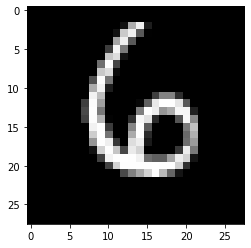

Prediction 9
Label 9


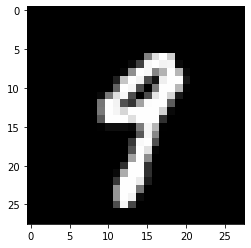

Prediction 5
Label 5


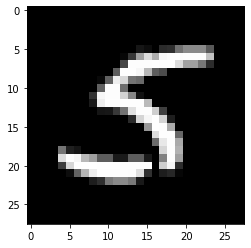

Prediction 6
Label 6


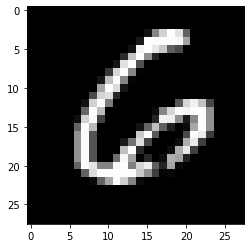

In [32]:
import random
for i in range(4):
    k = random.choice(range(len(test_X)))
    print('Prediction',AN.predict(test_X[k])[0])
    print('Label',test_y[k])
    plt.imshow(test_X[k],interpolation='nearest',cmap = 'gray')
    plt.show()